In [1]:
import json
import datetime
import pprint
import numpy as np
import pandas as pd

In [2]:
%%time
graph_data = []
with open('./dataForGraph.txt', 'r') as f:
    for line in f:
        graph_data.append(json.loads(line))

CPU times: user 1min 4s, sys: 15.5 s, total: 1min 19s
Wall time: 1min 24s


In [3]:
graph_data[0]

{'apply_info': {'apply_time': '2017-10-29 03:07:52',
  'apply_device_id': 'fbb7f166779a1d1d81e1f968b5362177',
  'apply_user_id': '029b50315c72439480d6d7d5a200f96c',
  'is_reject': 1,
  'num_of_applications': 2,
  'is_new_client': 1,
  'is_overdue': 0,
  'overdue_day': 0},
 'device_info': {'device_id': ['fbb7f166779a1d1d81e1f968b5362177',
   'df85ed6021e64d5fddc543d94d7a2a48'],
  'imsi': ['460026207112659'],
  'phone': ['eb667b47c22e49d342e8e5ac2bb216c3'],
  'mac': ['0f607264fc6318a92b9e13c65db7cd3c'],
  'idfv': [],
  'idfa': []},
 'contacts_info': {'0098fba3e69dd1d8d63bca4738ce7a37': ['1507172419315',
   '1507172419315'],
  '01b7aa571f37b979b792c8efb08f0d8d': ['1508983040173', '1508983040173'],
  '021bf8902d11e1df4a94727bfed34f41': ['1507172419315', '1507172419315'],
  '023648d6ec33854dd4e688142679e7ea': ['1507172419315', '1507172419315'],
  '038abe46bc7a2953437370aa5a99cb41': ['1505803404713', '1507172419315'],
  '061b5d3a4916e948f8fd2e902a10d2d8': ['1509198138913', '1509198138913'],


In [4]:
graph_data[1]['device_info']

{'device_id': ['f4d396e29ff742178e6d2c0120160646',
  '8756dc149dd15017a4301c7de9341a56'],
 'imsi': ['460017653615945'],
 'phone': ['2fc2d7baadaf8b92c759b304bbe74105'],
 'mac': ['0f607264fc6318a92b9e13c65db7cd3c'],
 'idfv': [],
 'idfa': []}

In [5]:
# construct a feature matrix
features = pd.DataFrame()
features['is_reject'] = [a['apply_info']['is_reject'] for a in graph_data]
features['num_of_applications'] = [a['apply_info']['num_of_applications'] for a in graph_data]
features['is_new_client'] = [a['apply_info']['is_new_client'] for a in graph_data]
features['overdue_day'] = [a['apply_info']['overdue_day'] for a in graph_data]
features['num_of_devices'] = [len(a['device_info']['device_id']) for a in graph_data]
features['num_of_phones'] = [len(a['device_info']['phone']) for a in graph_data]
def avg_call_duration(a, call_type, days):
    """
    Args:
        a: dict, application record in graph_data
        call_type: str, '1' for call in and '2' for call out
        days: int, how many days call to compute
    Return: average call duration
    """
    call_logs = [int(c['duration']) for c in a['calls_info']
                if c['type'] == call_type and
                (datetime.datetime.strptime(a['apply_info']['apply_time'], '%Y-%m-%d %H:%M:%S') -
                 datetime.datetime.fromtimestamp(int(c['date'])/1000)).days <= days]
    try:
        avg_duration = sum(call_logs) / len(call_logs)
    except:
        return 0.0
    return avg_duration
features['last_7d_avg_call_in_duration'] = [avg_call_duration(a, call_type='1', days=7) for a in graph_data]
features['last_7d_avg_call_out_duration'] = [avg_call_duration(a, call_type='2', days=7) for a in graph_data]
features['is_overdue'] = [a['apply_info']['is_overdue'] for a in graph_data]

In [8]:
features.head() 

,is_reject,num_of_applications,is_new_client,overdue_day,num_of_devices,num_of_phones,last_7d_avg_call_in_duration,last_7d_avg_call_out_duration,is_overdue
0,1,2,1,0,2,1,88.214286,79.967742,0
1,0,3,0,0,2,1,52.804878,36.057471,0
2,0,4,0,0,1,0,68.483333,23.833333,0
3,1,2,1,0,2,0,46.947368,65.388889,0
4,1,4,1,0,0,0,0.000000,0.000000,0


In [ ]:
features['overdue_day'>30]

In [ ]:
np.save('feature_matrix', features)

In [6]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [9]:
G= nx.from_pandas_dataframe(features, edge_attr = ['is_reject','num_of_applications','is_new_client','overdue_day','num_of_devices','num_of_phones','last_7d_avg_call_in_duration','last_7d_avg_call_out_duration','is_overdue'])

AttributeError: module 'networkx' has no attribute 'from_pandas_dataframe'

In [ ]:
class AttentionDrawer():

    def __init__(self, graph_builder):
        self.graph_builder = graph_builder

    def draw(self, sentence, attention=()):
        edge_matrix = ()
        nodes = self.graph_builder.get_nodes(sentence)

        size = len(attention) if len(attention) > 0 else len(nodes)
        if isinstance(self.graph_builder, DependencyGraph):
            edge_matrix = self.graph_builder.build(
                            sentence, size, return_label=True)
        matrix = attention
        if len(attention) == 0:
            matrix = self.graph_builder.build(sentence, size)
        graph = self._build(nodes, matrix, edge_matrix)
        return graph

    def _build(self, nodes, matrix, edge_matrix=()):
        graph = nx.Graph()
        _size = min(len(nodes), len(matrix))
        graph.add_nodes_from(nodes[i] for i in range(_size))
        for i in range(_size):
            for j in range(_size):
                if matrix[i][j] > 0:
                    if len(edge_matrix) == 0:
                        graph.add_edge(nodes[i], nodes[j],
                                       weight=matrix[i][j])
                    else:
                        graph.add_edge(nodes[i], nodes[j],
                                       weight=matrix[i][j],
                                       label=edge_matrix[i][j]
                                       
                                    

In [ ]:

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Build a dataframe with 4 connections
df = pd.DataFrame({'from': ['A', 'B', 'C', 'A'], 'to': ['D', 'A', 'E', 'C']})

# Build your graph
G = nx.from_pandas_edgelist(df, 'from', 'to')

# Plot it
nx.draw(G, with_labels=True)
plt.show()

In [18]:
graphnx = nx.read_edgelist(path=features)

In [16]:
graphnx.number_of_nodes()

0

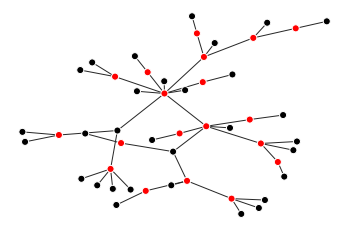

In [21]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.approximation.dominating_set import min_weighted_dominating_set

from grave import plot_network

network = nx.powerlaw_cluster_graph(50, 1, .2)
dom_set = min_weighted_dominating_set(network)

for node, node_attrs in network.nodes(data=True):
    node_attrs['is_dominator'] = True if node in dom_set else False

def color_dominators(node_attrs):
    if node_attrs.get('is_dominator', False):
        return {'color': 'red'}
    else:
        return {'color': 'black'}

fig, ax = plt.subplots()
plot_network(network, node_style=color_dominators)
plt.show()

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

# 1. Create the graph
g = nx.from_pandas_dataframe(freatures, source='name', target='club') 


AttributeError: module 'networkx' has no attribute 'from_pandas_dataframe'

<Figure size 864x864 with 0 Axes>